Hello, this is an SVM analysis based on the knowledge I could gather from the internet (:p) and from the notebook by [Niraj Verma](https://www.kaggle.com/nirajvermafcb/support-vector-machine-detail-analysis). Please do go through this notebook and let me know if it makes sense. Do critically evaluate and let me know where I can do better. Thanks

I have given few links below if anyone wants to understand the math behind it.

References:

https://towardsdatascience.com/understanding-support-vector-machine-part-1-lagrange-multipliers-5c24a52ffc5e

https://www.youtube.com/watch?v=ax8LxRZCORU

https://www.youtube.com/watch?v=_PwhiWxHK8o

The contents of the notebook are given below:<br>
- [About this Dataset](#About-this-Dataset)
- [Check the data](#Step-1:-Check-the-data)
- [EDA](#Step-2:-EDA)
- [Preprocessing and Model builiding](#Step-3:-Preprocessing-and-Model-builiding)


# About this Dataset

### Voice Gender
#### Gender Recognition by Voice and Speech Analysis

This database was created to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3,168 recorded voice samples, collected from male and female speakers. The voice samples are pre-processed by acoustic analysis in R using the seewave and tuneR packages, with an analyzed frequency range of 0hz-280hz (human vocal range).

The following acoustic properties of each voice are measured and included within the CSV:

- meanfreq: mean frequency (in kHz)
- sd: standard deviation of frequency
- median: median frequency (in kHz)
- Q25: first quantile (in kHz)
- Q75: third quantile (in kHz)
- IQR: interquantile range (in kHz)
- skew: skewness (see note in specprop description)
- kurt: kurtosis (see note in specprop description)
- sp.ent: spectral entropy
- sfm: spectral flatness
- mode: mode frequency
- centroid: frequency centroid (see specprop)
- peakf: peak frequency (frequency with highest energy)
- meanfun: average of fundamental frequency measured across acoustic signal
- minfun: minimum fundamental frequency measured across acoustic signal
- maxfun: maximum fundamental frequency measured across acoustic signal
- meandom: average of dominant frequency measured across acoustic signal
- mindom: minimum of dominant frequency measured across acoustic signal
- maxdom: maximum of dominant frequency measured across acoustic signal
- dfrange: range of dominant frequency measured across acoustic signal
- modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of -fundamental frequencies divided by the frequency range
- label: male or female

### Questions
- What other features differ between male and female voices?
- Can we find a difference in resonance between male and female voices?
- Can we identify falsetto from regular voices? (separate data-set likely needed for this)
- Are there other interesting features in the data?

#### Step 1: Check the data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
data = pd.read_csv('../input/voicegender/voice.csv')

In [3]:
data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [4]:
data.shape

(3168, 21)

In [5]:
data.describe([.25,.50,.75,.80,.90])

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
80%,0.203362,0.070910,0.215442,0.182861,0.246684,0.117819,3.131731,15.526993,0.934780,0.571437,0.230229,0.203362,0.173912,0.048387,0.277457,1.271781,0.097656,8.062500,8.039062,0.238269
90%,0.217670,0.079662,0.227426,0.200630,0.253571,0.132840,3.916198,27.293627,0.951267,0.671270,0.249010,0.217670,0.185188,0.050542,0.279070,1.560190,0.164062,9.421875,9.375000,0.324356
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [7]:
data.isna().sum() #no missing data

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

#### Step 2: EDA

In [8]:
#univariate
def dist_male(x):
    if x == 'label':
        pass
    else:
        data[x][data['label']=='male'].plot.kde()
        plt.xlabel(x)
        plt.show()

In [9]:
def dist_female(y):
    if y == 'label':
        pass
    else:
        data[y][data['label']=='female'].plot.kde(color='maroon')
        plt.xlabel(y)
        plt.show()

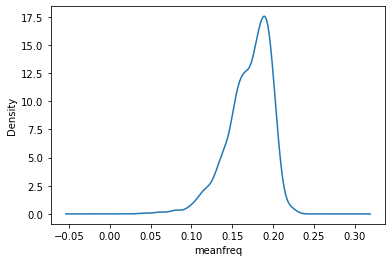

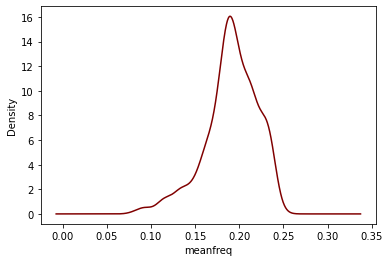

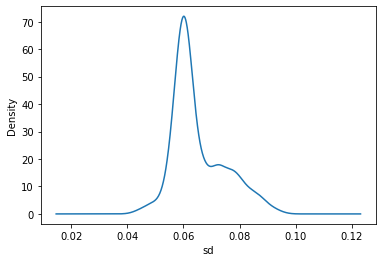

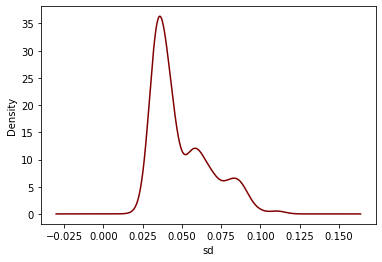

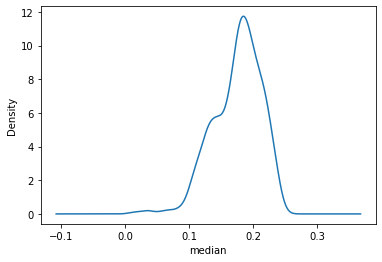

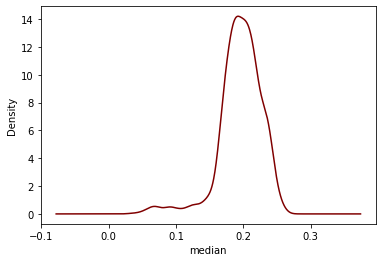

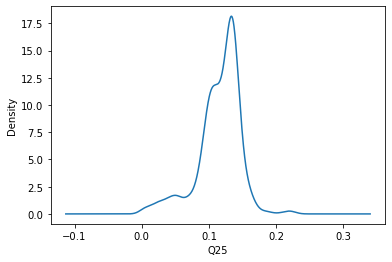

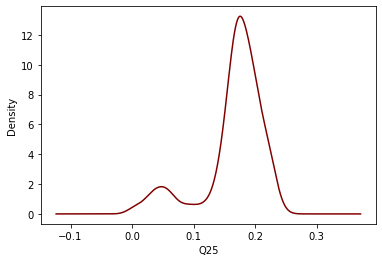

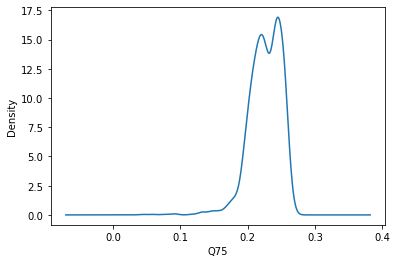

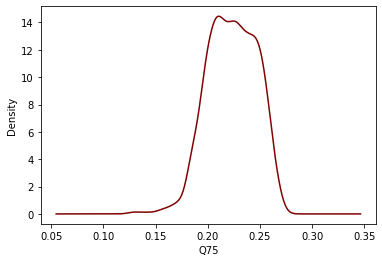

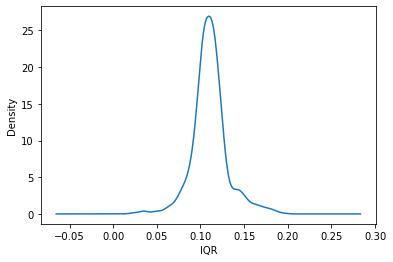

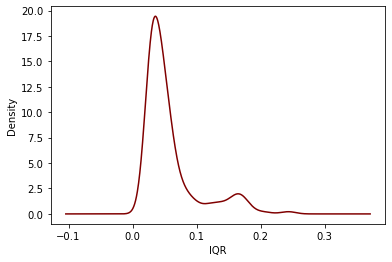

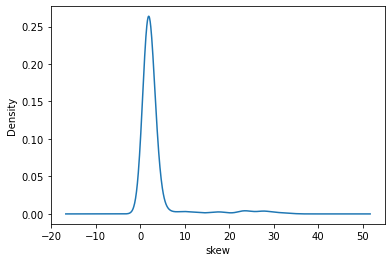

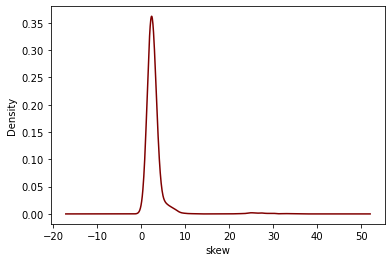

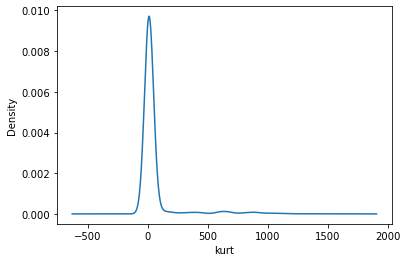

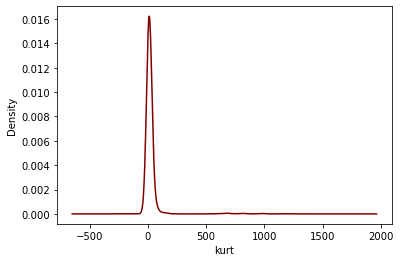

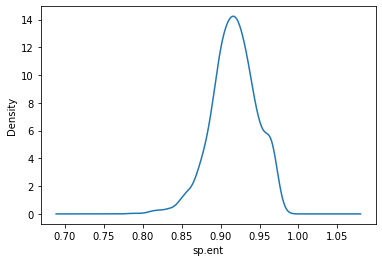

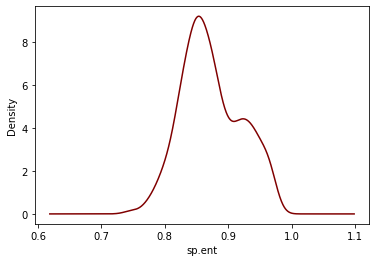

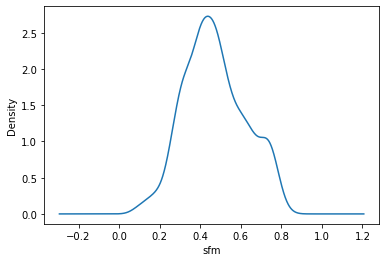

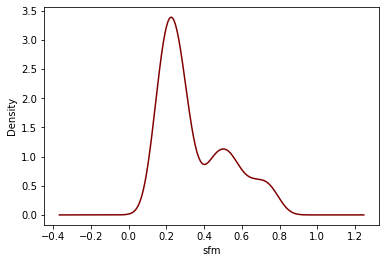

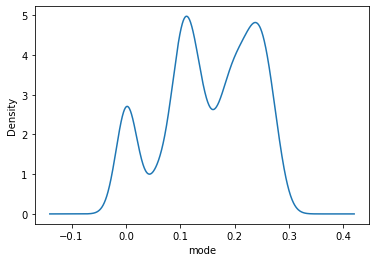

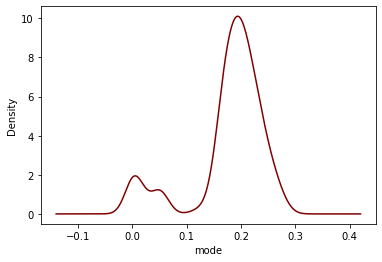

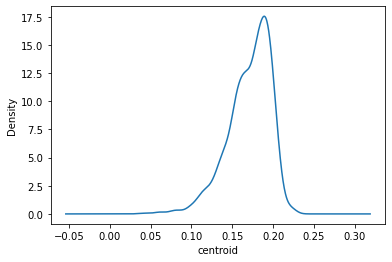

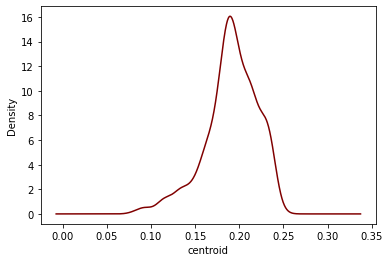

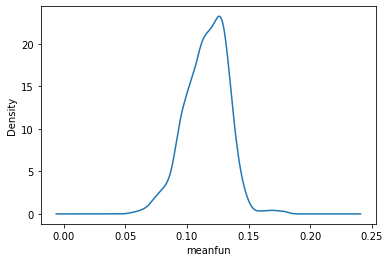

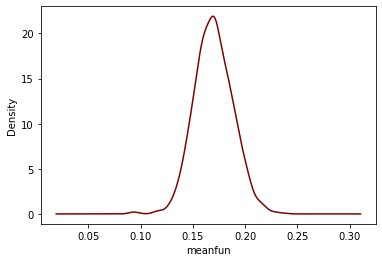

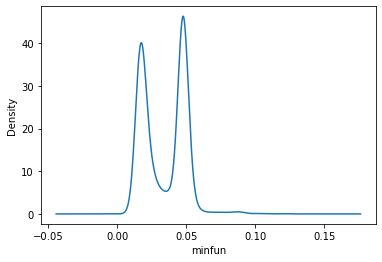

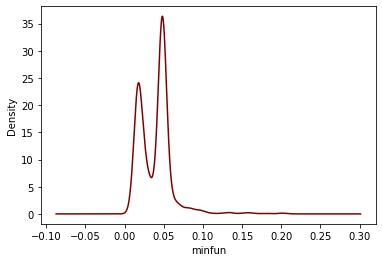

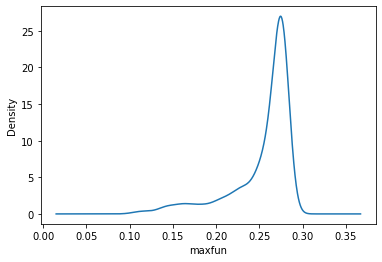

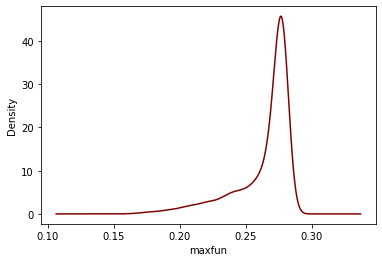

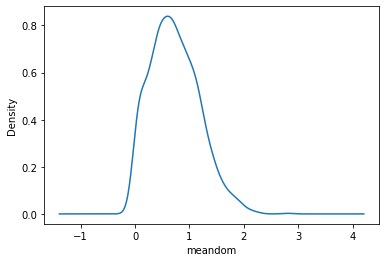

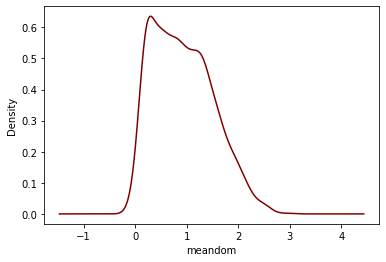

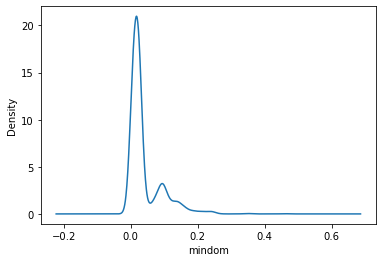

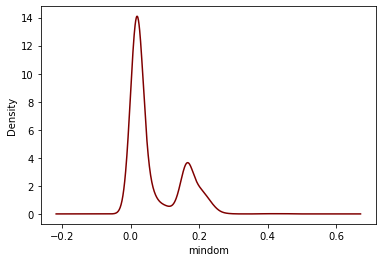

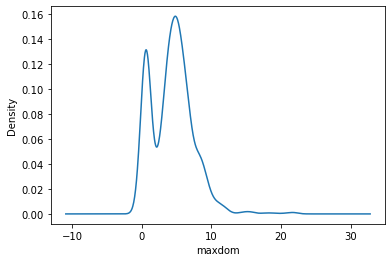

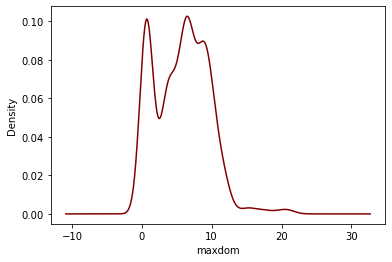

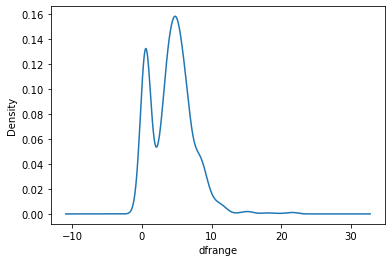

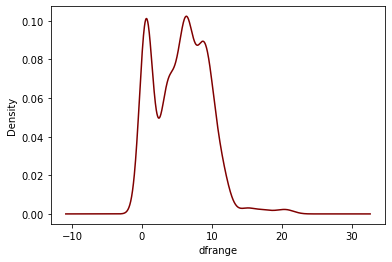

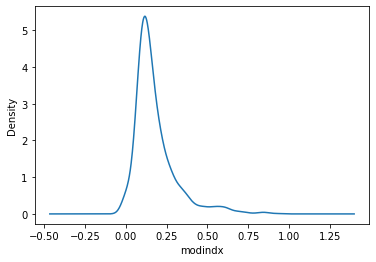

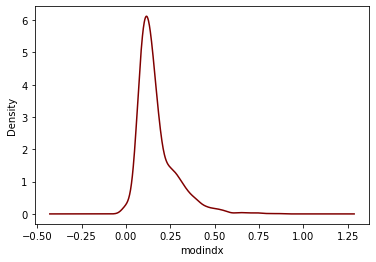

In [10]:
cols = data.columns.drop('label')


for j, i in enumerate(cols):
#     print(j)
    dist_male(i)
    dist_female(i)

In [11]:
data_male = data[data['label']=='male'].drop('label', axis=1)
data_female = data[data['label']=='female'].drop('label', axis=1)

In [12]:
def box_plt_m(x,i):
    sns.boxplot(x=x, data=data_male)
    plt.show()
    

def box_plt_f(x,i):
    sns.boxplot(x=x, data=data_female)
    plt.show()

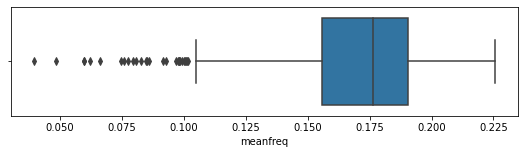

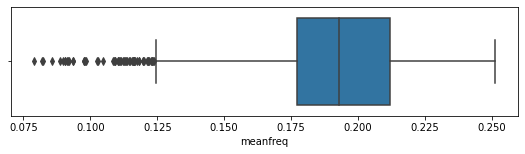

0


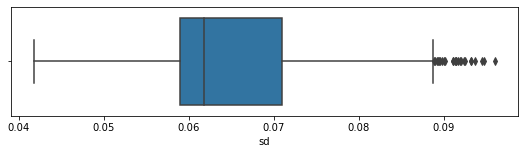

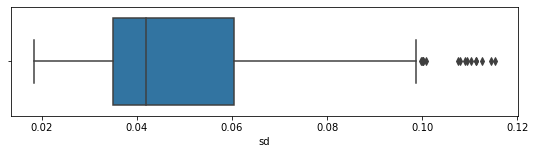

1


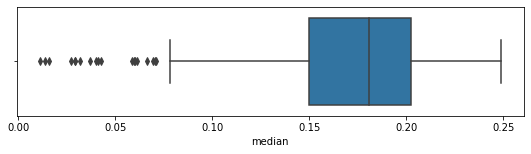

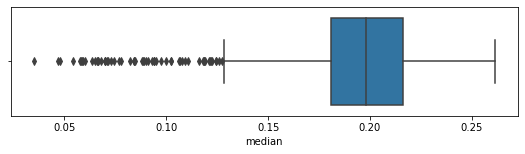

2


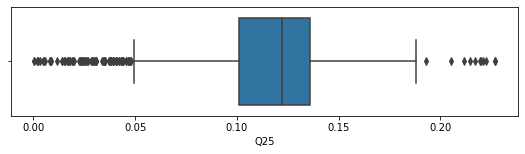

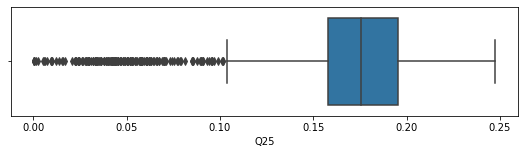

3


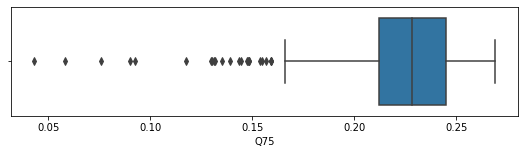

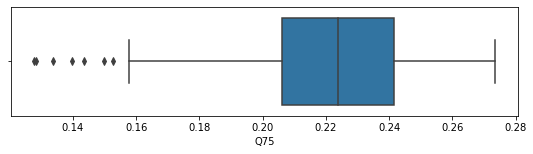

4


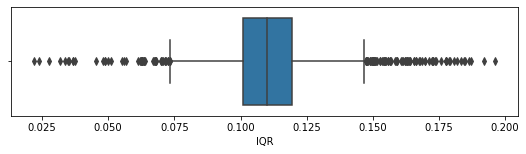

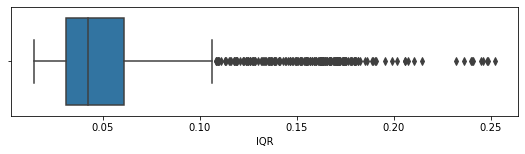

5


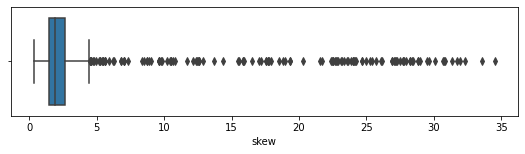

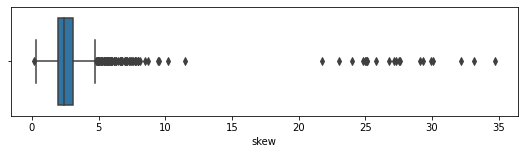

6


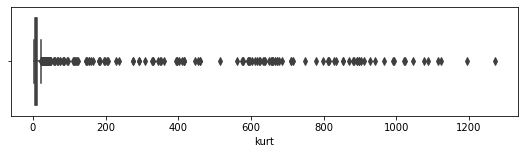

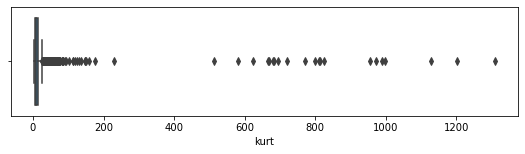

7


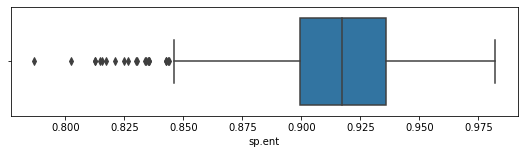

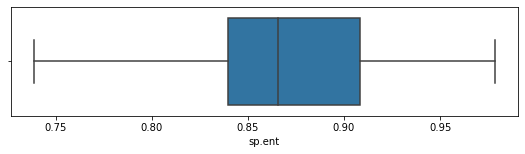

8


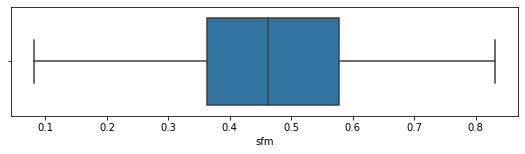

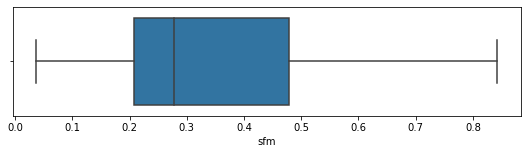

9


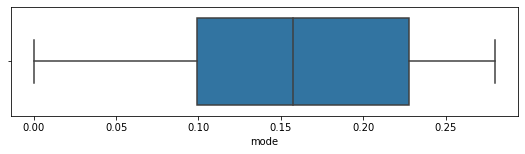

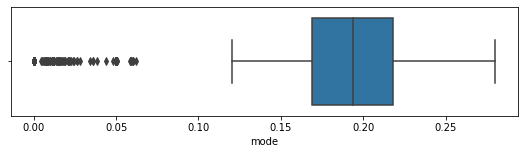

10


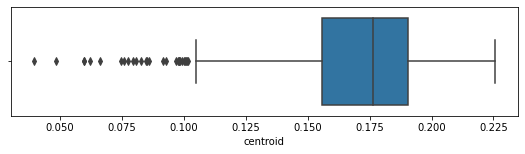

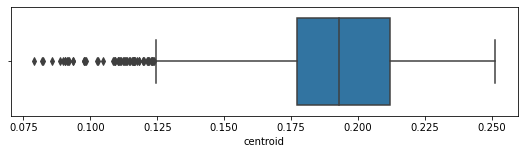

11


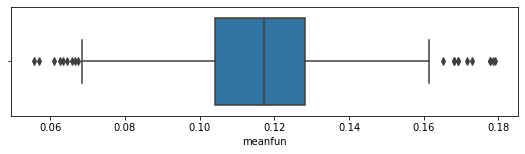

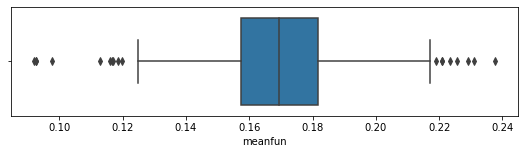

12


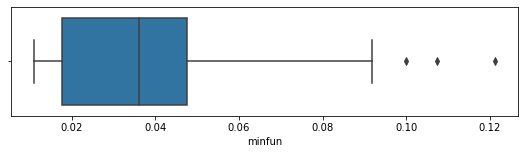

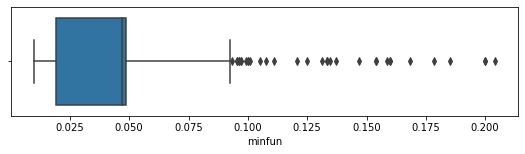

13


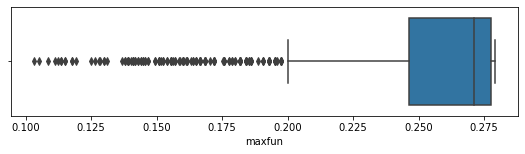

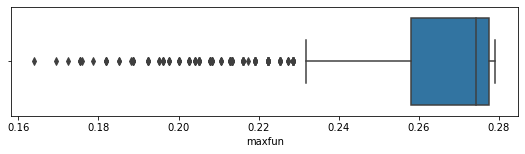

14


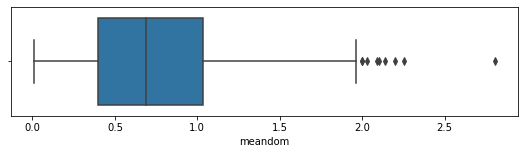

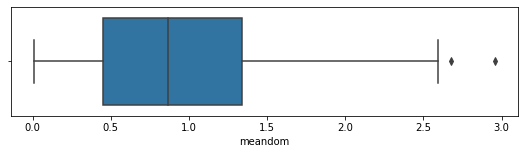

15


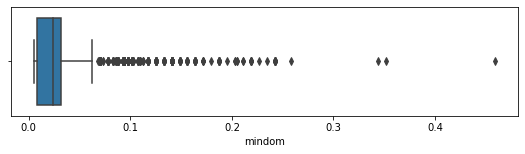

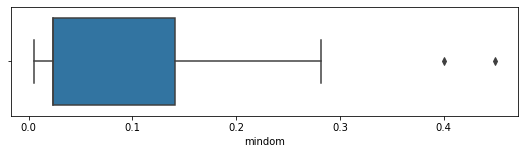

16


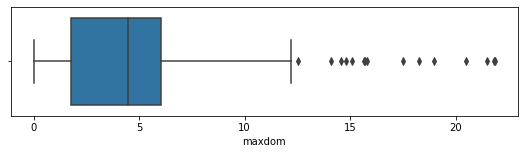

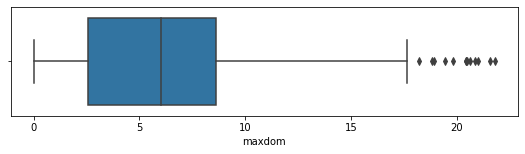

17


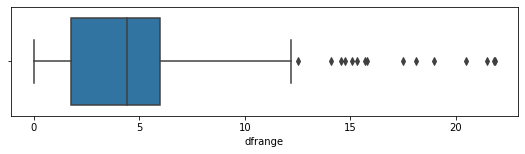

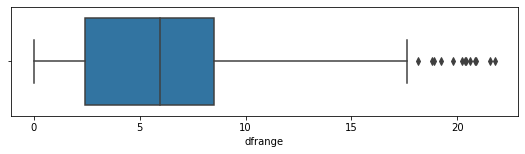

18


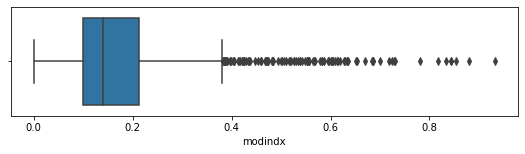

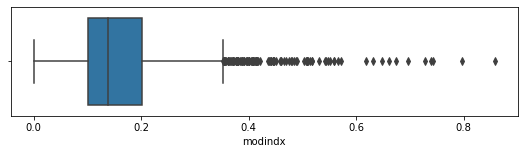

19


In [13]:
for j,i in enumerate(cols):
    plt.figure(figsize=(20,50))
    plt.subplot(21,2,j+1)
    box_plt_m(i,j)
    plt.figure(figsize=(20,50))
    plt.subplot(21,2,j+2)
    box_plt_f(i,j)
    print(j)

<b>Inference:</b>

#### What other features differ between male and female voices?

    - The meanfreq has a different mean, there are more outliers in the female as compared to male data
    - The standard deviation is more for male as compared to female
    - The median is slightly different for male and female with more outliers in female 
    - The Q25 has a lot of outliers to the left for female while for the male it is both sides but more on the left
    - The Q75 has also slightly different median
    - The IQR is significantly different for male and female with male IQR having outliers on both sides (low and high outliers)
    - The skew has a lot of outliers for both female and male
    - The sp.ent and sfm is almost similar for both male and female
    - The mode is also similar but has outliers for female
    - The centroid is similar but has outliers for both male and female
    - The meanfun and minfun is also similar, the distribution are different
    - The maxfun, meandom is almost same
    - The mindom is varies in distribution and male data points have a lot of outliers
    - The maxdom and dfrange are also similar
    - The modindx is same

#### Can we find a difference in resonance between male and female voices? <br>

There are a number of factors which determine the resonance characteristics of a resonator. Included among them are the following: size, shape, type of opening, composition and thickness of the walls, surface, and combined resonators. The quality of a sound can be appreciably changed by rather small variations in these conditioning factors

Source: Wikipedia

#### Can we identify falsetto from regular voices? (separate data-set likely needed for this)

Yes, a separate dataset will be needed.

In [14]:
#check the correlation between features
#bivariate
data.corr()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
meanfreq,1.000000,-0.739039,0.925445,0.911416,0.740997,-0.627605,-0.322327,-0.316036,-0.601203,-0.784332,0.687715,1.000000,0.460844,0.383937,0.274004,0.536666,0.229261,0.519528,0.515570,-0.216979
sd,-0.739039,1.000000,-0.562603,-0.846931,-0.161076,0.874660,0.314597,0.346241,0.716620,0.838086,-0.529150,-0.739039,-0.466281,-0.345609,-0.129662,-0.482726,-0.357667,-0.482278,-0.475999,0.122660
median,0.925445,-0.562603,1.000000,0.774922,0.731849,-0.477352,-0.257407,-0.243382,-0.502005,-0.661690,0.677433,0.925445,0.414909,0.337602,0.251328,0.455943,0.191169,0.438919,0.435621,-0.213298
Q25,0.911416,-0.846931,0.774922,1.000000,0.477140,-0.874189,-0.319475,-0.350182,-0.648126,-0.766875,0.591277,0.911416,0.545035,0.320994,0.199841,0.467403,0.302255,0.459683,0.454394,-0.141377
Q75,0.740997,-0.161076,0.731849,0.477140,1.000000,0.009636,-0.206339,-0.148881,-0.174905,-0.378198,0.486857,0.740997,0.155091,0.258002,0.285584,0.359181,-0.023750,0.335114,0.335648,-0.216475
IQR,-0.627605,0.874660,-0.477352,-0.874189,0.009636,1.000000,0.249497,0.316185,0.640813,0.663601,-0.403764,-0.627605,-0.534462,-0.222680,-0.069588,-0.333362,-0.357037,-0.337877,-0.331563,0.041252
skew,-0.322327,0.314597,-0.257407,-0.319475,-0.206339,0.249497,1.000000,0.977020,-0.195459,0.079694,-0.434859,-0.322327,-0.167668,-0.216954,-0.080861,-0.336848,-0.061608,-0.305651,-0.304640,-0.169325
kurt,-0.316036,0.346241,-0.243382,-0.350182,-0.148881,0.316185,0.977020,1.000000,-0.127644,0.109884,-0.406722,-0.316036,-0.194560,-0.203201,-0.045667,-0.303234,-0.103313,-0.274500,-0.272729,-0.205539
sp.ent,-0.601203,0.716620,-0.502005,-0.648126,-0.174905,0.640813,-0.195459,-0.127644,1.000000,0.866411,-0.325298,-0.601203,-0.513194,-0.305826,-0.120738,-0.293562,-0.294869,-0.324253,-0.319054,0.198074
sfm,-0.784332,0.838086,-0.661690,-0.766875,-0.378198,0.663601,0.079694,0.109884,0.866411,1.000000,-0.485913,-0.784332,-0.421066,-0.362100,-0.192369,-0.428442,-0.289593,-0.436649,-0.431580,0.211477


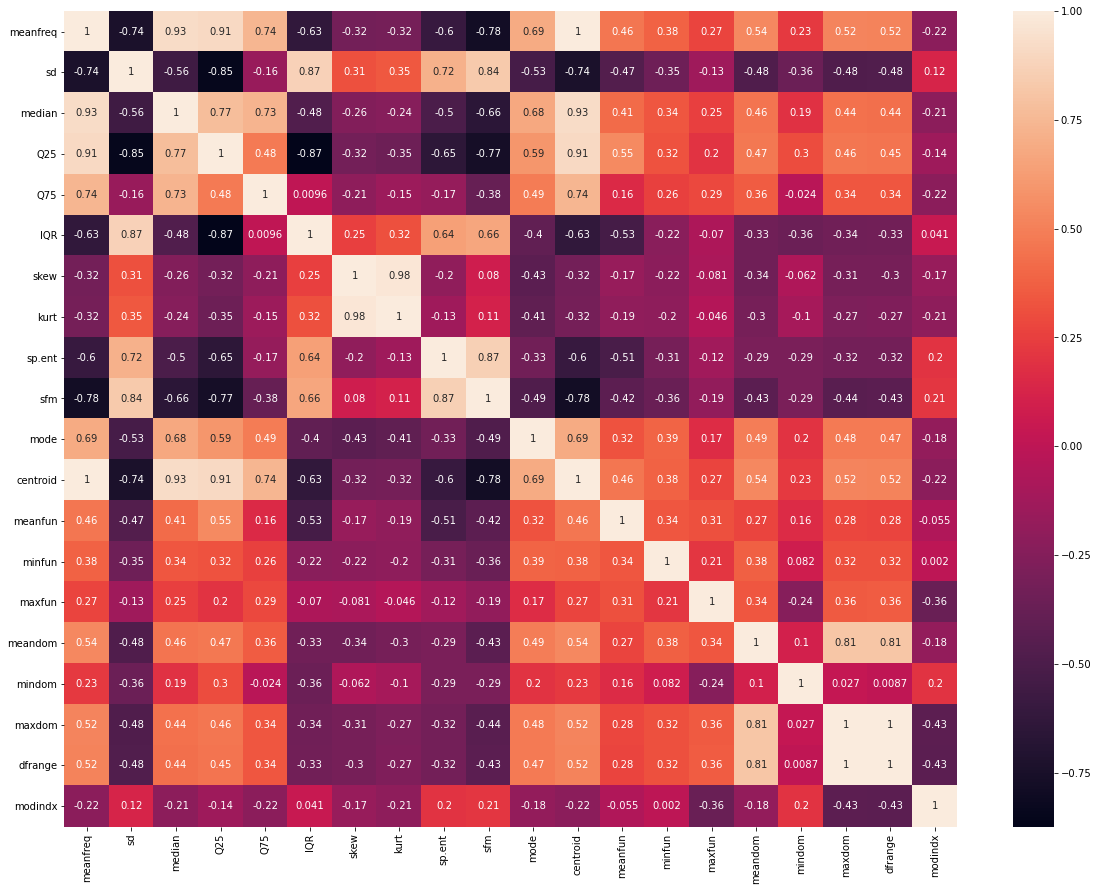

In [15]:
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True, fmt='.2g')

<b>Inference: </b>

#### Are there other interesting features in the data?

- Multi-collinearity is really high as coefficient constant is high for feature variables
- These can effect our models if we use Logistic, Linear Classifiers
    

In [16]:
# checking for more than .50 and -.50 correlation

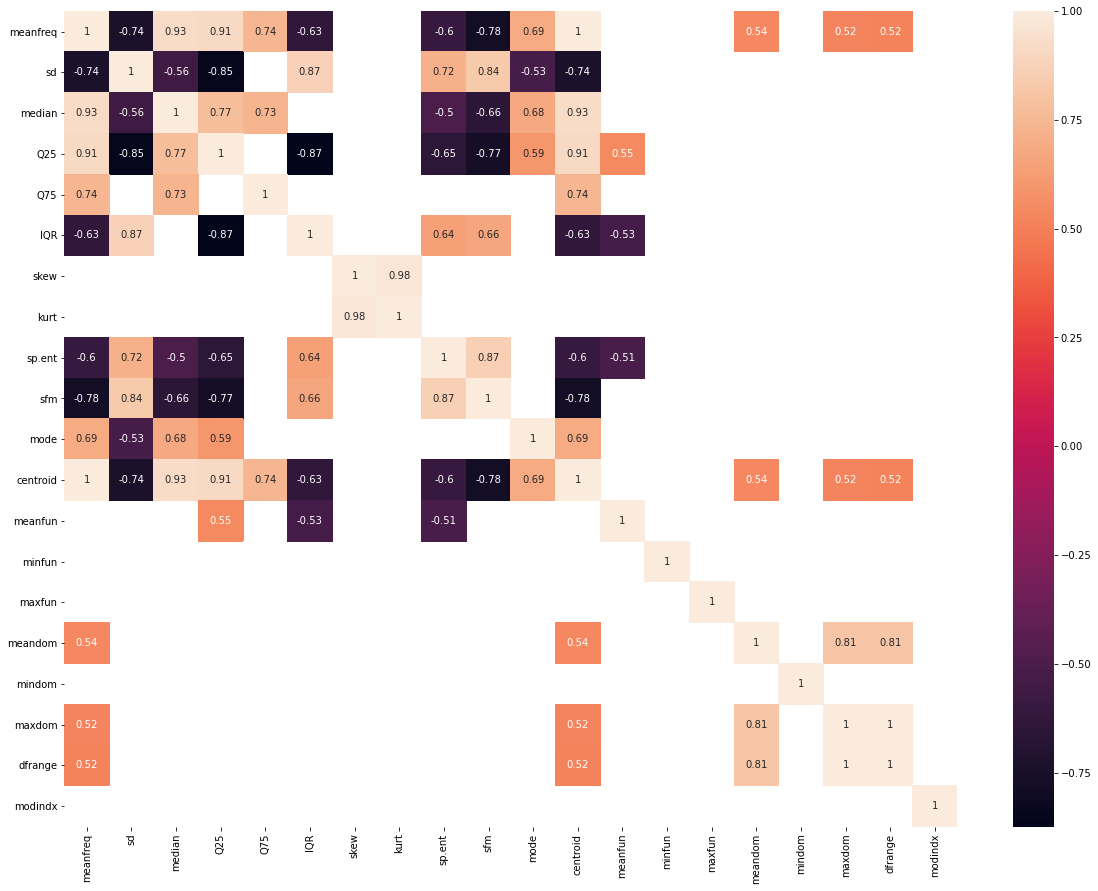

In [17]:
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True, fmt='.2g', mask=~(((data.corr()) <=-.50) | ((data.corr())>=.50)))

#### Since SVM are not that affected by multicollinearity, we will go to model building and cross validation process.

Before that we will check for class imbalance as well

In [18]:
print('The number of male in our output is: ',data[data['label']=='male'].shape[0])
print('The number of female in our output is: ',data[data['label']=='female'].shape[0])

The number of male in our output is:  1584
The number of female in our output is:  1584


#### Step 3: Preprocessing and Model builiding

First let us convert the object 'label' column type to category type

In [19]:
y = data.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([1, 1, 1, ..., 0, 0, 0])

Data standardization: Since SVM deals with distance to classify we need to standardize the data

In [20]:
from sklearn.preprocessing import StandardScaler

X = data.iloc[:,:-2]
std_scaler = StandardScaler()
std_scaler.fit(X)

X = std_scaler.transform(X)

In [21]:
#splitting into train test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=1)

First we shall try on default parameters

Default SVM (RBF)

In [22]:
from sklearn.svm import SVC
from sklearn import metrics

svc = SVC() #default parameters
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f'The score for this model {svc.__class__.__name__} is {metrics.accuracy_score(y_test, y_pred)}')

The score for this model SVC is 0.9789695057833859


Default SVM  (Linear)

In [23]:
svc = SVC(kernel='linear') #default parameters
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f'The score for this model {svc.__class__.__name__} is {metrics.accuracy_score(y_test, y_pred)}')

The score for this model SVC is 0.9758149316508938


Default SVM (Polynomial)

In [24]:
svc = SVC(kernel='poly') #default parameters
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f'The score for this model {svc.__class__.__name__} is {metrics.accuracy_score(y_test, y_pred)}')

The score for this model SVC is 0.961093585699264


The polynomial kernel did not do so well as compared to other kernels, but all have a high accuracy score


We need to check with <b>K fold cross validation </b> that if the results are same when we split the training and testing more times.

Default SVM (RBF)

In [25]:
from sklearn.model_selection import cross_val_score

svc = SVC()
score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(score)
print('The mean accuracy for the model on 10 K fold cross validation is: {%.3f}'%score.mean())

[0.93375394 0.95268139 0.96529968 0.96214511 0.96529968 0.99684543
 0.99053628 0.98422713 0.91455696 0.99367089]
The mean accuracy for the model on 10 K fold cross validation is: {0.966}


Default SVM (Linear)

In [26]:
svc = SVC(kernel='linear')
score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(score)
print('The mean accuracy for the model on 10 K fold cross validation is: {%.3f}'%score.mean())

[0.90851735 0.97160883 0.96845426 0.97476341 0.95899054 0.9873817
 0.99369085 0.98107256 0.94936709 0.98734177]
The mean accuracy for the model on 10 K fold cross validation is: {0.968}


Default SVM (Polynomial)

In [27]:
svc = SVC(kernel='poly')
score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
print(score)
print('The mean accuracy for the model on 10 K fold cross validation is: {%.2f}'%score.mean())

[0.89589905 0.94006309 0.94006309 0.92113565 0.94321767 1.
 0.98107256 0.96529968 0.86075949 0.9778481 ]
The mean accuracy for the model on 10 K fold cross validation is: {0.94}


<b>After K fold cross validation we get accuracy score for RBF and Linear as .97 and polynomial as .94</b>

The cross validation splits the data into train and test a number of times (here cv is 10) and gives us an accuracy score. Since scores are dependent on the data and the how the split occurred. Using cross validation we can reduce that error.

#### Taking different values of C and checking which is performing better

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy.

Reference: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

For large value of C, I am basically looking for every point to be correctly classified. I am not concerned with the width of the margin.

For small value of C, I am basically looking for the widest width between clusters of data points and do not mind misclassification

#### Putting different C and checking the result for linear model

In [28]:
C_range = list(range(1,26))


acc_score = []

for i in C_range:
    svc = SVC(kernel='linear', C=i)
    score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(score.mean())
print('The best mean accuracy for the model on 10 K fold cross validation with a range of C value (0-25) is: {} and index {}'.format(max(acc_score), acc_score.index(max(acc_score))))
    

The best mean accuracy for the model on 10 K fold cross validation with a range of C value (0-25) is: 0.9687497504292617 and index 6


Text(0, 0.5, 'Cross-Validated Accuracy')

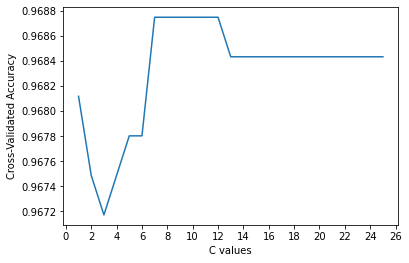

In [29]:
#plotting a graph

plt.plot(C_range, acc_score)
plt.xticks(np.arange(0,27,2))
plt.xlabel('C values')
plt.ylabel('Cross-Validated Accuracy')

In [30]:
#fine tuning to see which c is the best

In [31]:
C_range = list(np.arange(7,13,.1))

acc_score = []

for i in C_range:
    svc = SVC(kernel='linear', C=i)
    score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(score.mean())
print('The best mean accuracy for the model on 10 K fold cross validation with a range of C value (0-25) is: {} and index {}'.format(max(acc_score), acc_score.index(max(acc_score))))


The best mean accuracy for the model on 10 K fold cross validation with a range of C value (0-25) is: 0.9687497504292617 and index 0


Text(0, 0.5, 'Cross-Validated Accuracy')

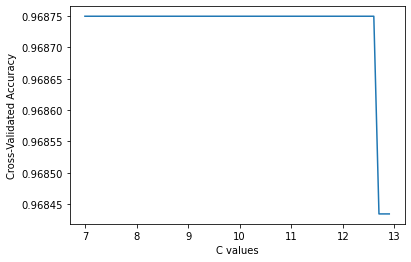

In [32]:

plt.plot(C_range, acc_score)
plt.xticks(np.arange(7,14,1))
plt.xlabel('C values')
plt.ylabel('Cross-Validated Accuracy')

<b>Inference:</b>
We have a range of C's (7,12) that have the same accuracy. C is the number that when we increase, we tell the classifer that we want all points to be correctly classified, hence the width will be small. 

We also are testing with linear kernel, which is not much affected by C and Gamma as you see below. (for this dataset)

Also the model evaluation is done on accuracy, which is (true positive + true negative) / (true positive + true negative + false positive + false negative)

In [33]:
#checking Gamma for kernel=linear

In [34]:
gamma_range = [.00001,.0001,.001,.01,.1,1,10,100]


acc_score = []

for i in gamma_range:
    svc = SVC(kernel='linear', gamma=i)
    score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(score.mean())
# print('The best mean accuracy for the model on 10 K fold cross validation with a range of C value (0-25) is: {} and index {}'.format(max(acc_score), acc_score.index(max(acc_score))))
acc_score  

[0.9681188356027632,
 0.9681188356027632,
 0.9681188356027632,
 0.9681188356027632,
 0.9681188356027632,
 0.9681188356027632,
 0.9681188356027632,
 0.9681188356027632]

Gamma has no effect on the model with kernel as linear

In [35]:
#checking c and Gamma for kernel=rbf

In [36]:
C_range = list(range(1,25))


acc_score = []

for i in tqdm(C_range):
    svc = SVC(kernel='rbf', C=i)
    score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(score.mean())
# print('The best mean accuracy for the model on 10 K fold cross validation with a range of C value (0-25) is: {} and index {}'.format(max(acc_score), acc_score.index(max(acc_score))))

acc_score

100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


[0.9659016491634389,
 0.9659016491634389,
 0.9655851934672365,
 0.9655861917501897,
 0.9640079064009903,
 0.9633769915744919,
 0.9621141636385417,
 0.962429621051791,
 0.9608513357025916,
 0.9595895060495948,
 0.9602214191590465,
 0.9592730503533922,
 0.9595905043325482,
 0.9592740486363456,
 0.9592740486363456,
 0.958327676396598,
 0.9576967615700995,
 0.9580122189833487,
 0.9586441320928005,
 0.9583286746795514,
 0.958960587789003,
 0.958960587789003,
 0.9586451303757538,
 0.958960587789003]

Text(0, 0.5, 'Cross-Validated Accuracy')

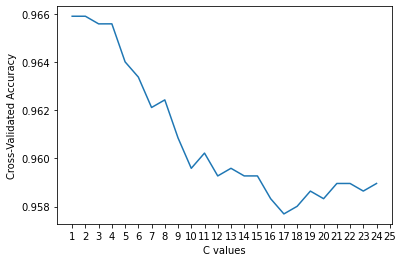

In [37]:
plt.plot(C_range, acc_score)
plt.xticks(np.arange(1,26,1))
plt.xlabel('C values')
plt.ylabel('Cross-Validated Accuracy')

In [38]:
gamma_range = [.00001,.0001,.001,.01,.1,1,10,100]


acc_score = []

for i in gamma_range:
    svc = SVC(kernel='rbf', gamma=i)
    score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(score.mean())
print('The best mean accuracy for the model on 10 K fold cross validation with a range of gamma is: {} and index {}'.format(max(acc_score), acc_score.index(max(acc_score))))
acc_score  

The best mean accuracy for the model on 10 K fold cross validation with a range of gamma is: 0.9687487521463083 and index 3


[0.5606866190152937,
 0.8895050513117437,
 0.9548646328315298,
 0.9687487521463083,
 0.9652697360539871,
 0.9223305913828217,
 0.6126891746196541,
 0.4993690851735016]

Text(0, 0.5, 'Cross-Validated Accuracy')

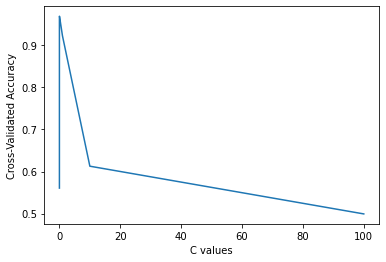

In [39]:
plt.plot(gamma_range, acc_score)
# plt.xticks(np.arange(0,9))
plt.xlabel('C values')
plt.ylabel('Cross-Validated Accuracy')

C and gamma change on every variation, with C between 1-2 giving us the highest accuracy. Gamma = .01 gives us the highest model accuracy. 

<b>Taking both gamma and C value together</b>

In [40]:
gamma_range = [.00001,.0001,.001,.01,.1,1,10,100]
C_range = list(range(1,25))


acc_score = []


for j in tqdm(gamma_range):
    for i in C_range:
        svc = SVC(kernel='rbf', C=i, gamma=j)
        score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
        acc_score.append(score.mean())
# print('The best mean accuracy for the model on 10 K fold cross validation with a range of C value (0-25) is: {} and index {}'.format(max(acc_score), acc_score.index(max(acc_score))))

temp = pd.DataFrame(acc_score)

100%|██████████| 8/8 [10:01<00:00, 75.23s/it]


In [41]:
temp['gamma_C'] = [(x,y) for x in gamma_range for y in C_range]


Text(0, 0.5, 'Cross-Validated Accuracy')

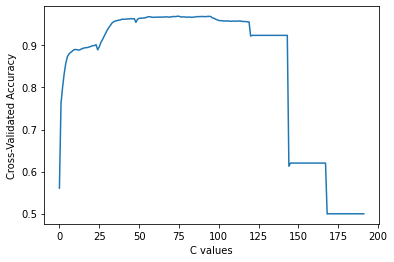

In [42]:
plt.plot(temp[0])
# plt.xticks(np.arange(0,27,2))
plt.xlabel('C values')
plt.ylabel('Cross-Validated Accuracy')

In [43]:
temp.sort_values(by=0,ascending=False)

temp.iloc[75,:]

0            0.96938
gamma_C    (0.01, 4)
Name: 75, dtype: object

The highest accuracy of .969 with kernel as rbf is with gamma = 0.01 and C = 4

Using the default parameters we did not get a high accuracy for the model with poly kernel. But we can see if there is any change when we have different degrees.

In [44]:
degrees = [2,3,4,5,6]

acc_score = []

for i in degrees:
    svc = SVC(kernel='poly', degree=i)
    score = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(score.mean())

print('The mean accuracy for the model on 10 K fold cross validation is: {}'.format(acc_score))

The mean accuracy for the model on 10 K fold cross validation is: [0.863281156410973, 0.942535838358024, 0.8370792237351756, 0.872154893583037, 0.781541748193108]


Text(0, 0.5, 'Cross-Validated Accuracy')

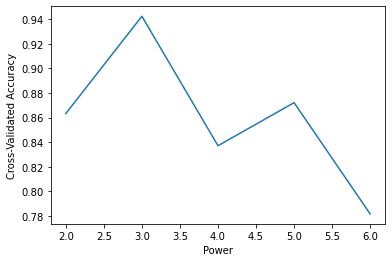

In [45]:
plt.plot( degrees, acc_score)
plt.xlabel('Power')
plt.ylabel('Cross-Validated Accuracy')

The accuracy is highest for degree = 3 and goes down. As you increase the degree the complexity of the model increases and may cause overfitting.

#### The best accuracy was with rbf kernel model using gamma with gamma = 0.01 and C = 4

#### Checking on f1 and roc_auc score

In [46]:
svc = SVC(kernel='rbf', C=4, gamma=.01)
score = cross_val_score(svc, X, y, cv=10, scoring='f1')
score.mean()

0.9694741763478266

In [47]:
svc = SVC(kernel='rbf', C=4, gamma=.01)
score = cross_val_score(svc, X, y, cv=10, scoring='roc_auc')
score.mean()

0.9932485924385203